## CHAVEZ BECERRA Cristian Alejandro

# IMA 208 TP5: homography estimation

In [195]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In this practical work, we will study how to estimate an homography between two given images. We will consider both the simple DLT algorithm (part I) and the RANSAC algorithm (part II).

To reduce the time you need for this practical work, we will use a few pre-implemented functions of openCV. Make sure that your library installation is correct before starting to work.

# Part 1: homography estimation from hand-selected keypoints: DLT algorithm

We assume that we have an image of a documents suffering from severe perspective distortion. The objective of this part is to warp this image (denoted in the following as img2) to remove the distortion using a reference image beeing in the desired pose (denoted as img1).

The following cell enables to vizualize the images using openCV.

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x1b618d829d0>)

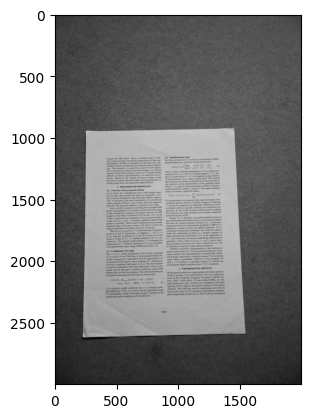

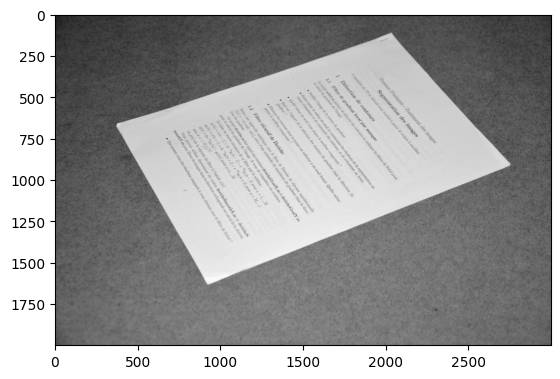

In [196]:
img1 = cv2.cvtColor(cv2.imread('Feuille_redressee.jpg'),cv2.COLOR_BGR2GRAY) # Reference image
img2 = cv2.cvtColor(cv2.imread('Feuille.jpg'),cv2.COLOR_BGR2GRAY) # Image to be processed

plt.figure(),plt.imshow(img1,cmap='gray')
plt.figure(),plt.imshow(img2,cmap='gray')

To correct the homography beetween the to images, we will need some points to match between the two images.

**Question:** how many points do you at least need to estimate the homography? Why?

**Answer:**
We need at least 4 corresponding points in each image. This is because the homography matrix has 8 degrees of freedom (9 elements, but it's up to scale), and each corresponding point pair provides 2 equations (x and y coordinates), resulting in a total of 8 equations.

With 4 or more point correspondences, we can set up a system of linear equations to solve for the elements of the homography matrix.

**Implementation:** to estimate the homography, some matching keypoints between the reference image and the to-be-porcessed one are given below. They here correspond to the corners of the two documents.

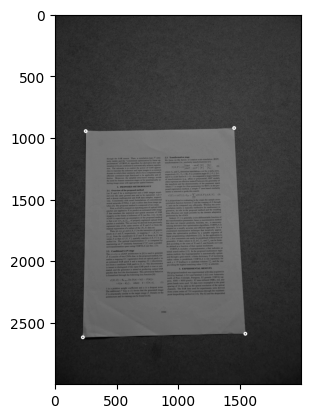

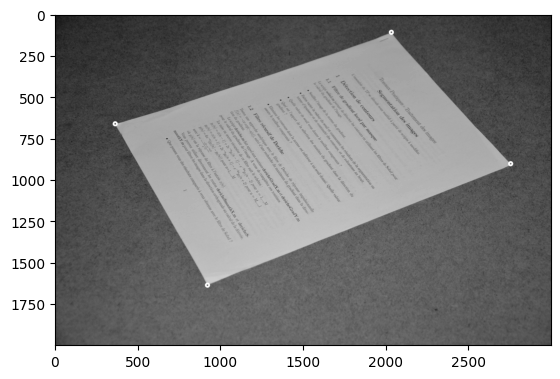

In [197]:
pts1 = [[248,949],[1450,924],[1541,2592],[225,2621]] # Keypoints for img1. Should be a list in format [[first_point_row,first_point_column],[second_point_row,second_point_column],...]
pts2 = [[2030,110],[2750,904],[920,1638],[363,663]] # Keypoints for img2,  keep the same order of the points as pts1.

# Below, we convert the points you found above into cv2 points object for vizualization (no need to change anything)
kp1 = [cv2.KeyPoint(pt[0], pt[1], 1) for pt in pts1]
kp2 = [cv2.KeyPoint(pt[0], pt[1], 1) for pt in pts2]

for i in range(len(pts1)):
    img1c=cv2.circle(img1,pts1[i],radius=10,color=(255,0,0),thickness=10)
plt.figure(),plt.imshow(img1c,cmap='gray')

for i in range(len(pts2)):
    img2c=cv2.circle(img2,pts2[i],radius=10,color=(255,0,0),thickness=10)
plt.figure(),plt.imshow(img2c,cmap='gray')

pts1 = np.array(pts1).T # In all the following, we will use the convention that np.shape(pts1) = [2,number_of_points]
pts2 = np.array(pts2).T # In all the following, we will use the convention that np.shape(pts1) = [2,number_of_points

**Visualize** the keypoints you found above to check that they are properly assigned.

Now, we will start implementing the DLT.

**Question:** recall what the DLT is. Give a pseudo code. What are its potential flaws and strengths?

**Answer:**

**DLT (Direct Linear Transform) Algorithm:**

DLT is a method used to estimate the homography matrix that relates corresponding points between two images. Here's a summary along with pseudocode:

The DLT algorithm estimates the homography matrix \( H \) by solving 

$$\arg\min_{\mathbf{h} \in \mathbb{R}^9} \left\| \mathbf{Ah} \right\|_2^2 \quad \text{s.t.} \quad \left\| \mathbf{h} \right\|_2^2 =1$$

**Pseudocode:**
1. **Input:**
   - Corresponding points in image 1:$  (x_1, y_1), (x_2, y_2), ..., (x_n, y_n)  $
   - Corresponding points in image 2:$  (u_1, v_1), (u_2, v_2), ..., (u_n, v_n)  $

2. **Normalization of $\mathbf{x}_i$**:

- Using a similarity transformation we center and scale the points $\mathbf{x}_i$ , taking into account that the average distance from the origin should be $\sqrt{2}$.

3. **Normalization of $\mathbf{u}_i$**:

- Using a similarity transformation we center and scale the points $\mathbf{u}_i$ , taking into account that the average distance from the origin should be $\sqrt{2}$.

4. **Compute matrix $\mathbf{A}_i$**:

- Assemble the $n 2 \times 9$ matrices $\mathrm{A}_i$ into a single $2 n \times 9$ matrix $\mathrm{A}$. $\mathbf{A} = \begin{bmatrix}
0 & 0 & 0 & -x_i & -y_i & -1 & x_i' y_i & x_i' x_i & x_i' \\
x_i & y_i & 1 & 0 & 0 & 0 & -x_i' y_i & -y_i' y_i & -y_i' \\
\end{bmatrix}
$

5. **Solve for $\mathbf{H}$**:
- Obtain the SVD of A . The unit singular vector corresponding to the smallest singular value is the solution $h$. Specifically, if $A=U D V^{\top}$ with $D$ diagonal with positive diagonal entries, arranged in descending order down the diagonal, then $\mathbf{h}$ is the last column of $\mathrm{V}$.
- The matrix $H$ is determined from $h$, which is reshaped into a $3 \times 3$ matrix H$
   
4. **Output:**
   - Homography matrix \( H \)

**Potential Flaws and Strengths:**

**Flaws:**
- Sensitivity to outliers: DLT can be sensitive to outliers, as it minimizes the overall error without robustness measures. Outliers can significantly affect the estimation.
- Degenerate configurations: DLT may fail to estimate accurate homographies in cases of degenerate configurations, such as when points are co-planar or nearly co-planar.

**Strengths:**
- Simplicity: DLT is relatively simple to implement and understand compared to more complex algorithms.
- Flexibility: It can handle arbitrary transformations between images, not just planar transformations, making it versatile for various applications.
- No assumptions about the scene: DLT does not require prior knowledge about the scene or the cameras, making it applicable in general scenarios.


The first step of the DLT algorithm is to normalize the image point.

**Question:** Recall why the normalization is important. Recall how to do it.

**Answer:**

Normalizing the data in DLT is important because the matrix A can be ill conditioned (close to a singular matrix)
which will compromise the singular value decomposition (SVD) used to get the solution, which can change a lot with small variations of A such as noise.

How to do it:


(i) Compute a similarity transformation T, consisting of a translation and scaling, that takes points $x_i$ to a new set of points $\hat{x}_i$ such that the centroid of the points $\hat{x}_i$ is the coordinate origin (0,0), and their average distance from the origin is √2.
(ii) Compute a similar transformation T' for the points in the second image, transforming points $x_i$ to $\hat{x}_i$.

In the following, we will perform the normalization using the so called *homogeneous* coordinates of the keypoints. The main idea is to add a last coordinate equal to one for each point. The point (x,y) thus becomes (x,y,1) in homogeneous coordinate.

The advantage is that we will be able to do the normalization using a simple matrix product : X_norm = T@X.

**Fill** the blanks in the below implementation.

In [198]:
def normalize_image_points(imageEucl):
    """
    Input: 2D list with x,y image points
    Output: normalized data points
    """

    print("Normalizing data using similarity matrix...")
    print(imageEucl)
    mean, std = np.mean(imageEucl, axis=1), np.std(imageEucl) # To be filled, (elementwise) mean and std of the data points
    
    # Image in homogeneous coordinate
    image = np.vstack((imageEucl, np.ones((imageEucl.shape[1])))) # Image in homogeneous coordinate
    

    # Define a similarity matrix enabling to normalize the data. Write the cooefficients in Tranformation such that image_norm = image@Transformation
    Transformation = np.array([ [np.sqrt(2)/std, 0, -mean[0]*np.sqrt(2)/std],
                                [0, np.sqrt(2)/std, -mean[1]*np.sqrt(2)/std],
                                [0, 0, 1]   ])
    
    #Transformation = np.linalg.inv(Transformation)

    # Apply transformation on data points
    image_norm = Transformation@image
    
    # Retrieve normalized image in the original input shape (25, 2)
    image_norm = image_norm[0:2,:]

    return image_norm, Transformation

**Question:** Verify that your data looks properly normalized.

In [199]:
normalize_image_points(np.array(pts1))

Normalizing data using similarity matrix...
[[ 248 1450 1541  225]
 [ 949  924 2592 2621]]


(array([[-1.00759739,  0.95216323,  1.10053113, -1.04509697],
        [-1.34101756, -1.38177798,  1.33775673,  1.38503881]]),
 array([[ 1.63041649e-03,  0.00000000e+00, -1.41194068e+00],
        [ 0.00000000e+00,  1.63041649e-03, -2.88828281e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]))

The second step is to compute the A matrix from the normalized data points.

**Fill** the blanks in the function below.

**Question:** justify the shape of the A matrix.

**Answer:**

- For each $\left\{\mathbf{x}_i \leftrightarrow \mathbf{x}_i^{\prime}\right\}$ , we obtain an equation: $\mathbf{A}_i \mathbf{h} = 0$

 - As we need 4 point correspondances ( with non-colinear points) at least, we stack the
different equations to obtain
$$\mathbf{A} \mathbf{h} = 0$$

with $\mathbf{A} ∈ ℝ^\mathbf{2Ix9}$ , with $\mathbf{I}$ the number of point correspondances.

So, in this specific case

$$\mathbf{A} ∈ ℝ^\mathbf{8x9}$$

**Answer:**

In [200]:
def compute_matrix_A(points1, points2, no_points):
    """
    Input: Already normalized correspondences for image1 and image2
    Output: Matrix A as defined in Zisserman p. 91
    """

    A = []

    for i in range(0, no_points):
        x, y = points1[0, i], points1[1, i] # Denote the coordinate in image 1 x and y for shortcut
        x_prime, y_prime = points2[0, i], points2[1, i] # Denote the coordinate in image 2 x_prime and y_prime for shortcut

        # Create A_i according to the fomula given in class
        # here we are assuming w_i and w_i_prime are one
        A.append([0, 0, 0, -x, -y, -1, y_prime*x, y_prime*y, y_prime])
        A.append([x, y, 1, 0, 0, 0, -x_prime*x, -x_prime*y, -x_prime])
    print()
    print("Stacked matrix A shape:", np.shape(A))

    return np.asarray(A)



We are now ready to code the whole homography computation function. 

**Fill** the gaps below.

In [201]:
def compute_homography(pts1,pts2):

    # Set data points to numpy arrays
    no_points = pts1.shape[1] # Number of points

    # Normalize the data
    image1_normalized, T = normalize_image_points(pts1)
    image2_normalized, T_prime = normalize_image_points(pts2)
    
    # Get matrix A
    # A = ...
    A = compute_matrix_A(image1_normalized, image2_normalized, no_points)

    # Compute SVD of A
    U, S, V = np.linalg.svd(A)
    V = V.T # So that A = USV.T
    
    # Get last column of V (this is the vector h)
    h = V[:,-1]
    
    # Obtain homography by reshaping h (H tilde)
    print()
    print("Reshaping to get homography H_tilde...")
    H_tilde = h.reshape(3,3)

    # Denormalize to obtain homography (H) using the transformations and generalized pseudo-inverse
    H = np.linalg.inv(T_prime)@H_tilde@T

    print()
    print("Denormalized to obtain homography H for 2D data points...")
    print("Matrix H:")
    print(H)
    
    return H

**Question:** Apply the compute_homography function to warp the document image 2 into the perspective of document 1. Any comment ?

Normalizing data using similarity matrix...
[[ 248 1450 1541  225]
 [ 949  924 2592 2621]]
Normalizing data using similarity matrix...
[[2030 2750  920  363]
 [ 110  904 1638  663]]

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[ 1.85076958e-01 -6.02783511e-01  1.75577622e+03]
 [ 3.50026235e-01  2.02580262e-01 -2.12424774e+02]
 [-6.01779177e-05 -4.71184896e-06  6.25126583e-01]]


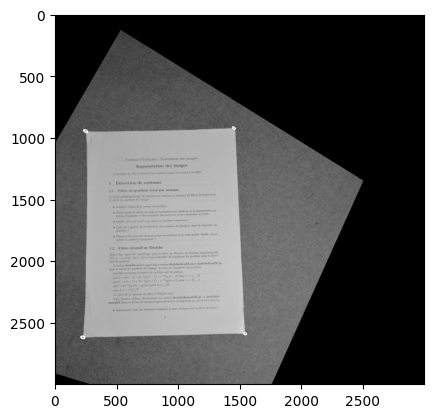

In [202]:
H = compute_homography(pts1,pts2)
homography_matrix_normalized = H
result = cv2.warpPerspective(img2, np.linalg.inv(homography_matrix_normalized),(3000,3000))
plt.imshow(result,cmap='gray')

**Answer:** We can see that without errors in the matching keypoints the algorithm works properly, this is because, since we don't have noise, there is an exact solution to

$$\mathbf{A} \mathbf{h} = 0$$

**Question:** test the sensitivity of the above algorithm to errors in the matching keypoints. Are you able to obtain good results if you have a false match?

Answer to the same question is you have more matching points than the corners.

**Answer:**

Since DLT is sinsible to outliers, we can see that if we integrate errors in the matching keypoints, we don't obtain good results, since such point mismatch severely disturb the least-square based homography estimators

When adding more matching points than the corners, (that are not errors) we can see that the algorithm works well still since it's still able to find a good approximation

Normalizing data using similarity matrix...
[[ 248 1450 1541  225]
 [ 949  924 2592 2621]]
Normalizing data using similarity matrix...
[[2040 2750  800  363]
 [  92  904 1500  400]]

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[ 1.07501862e-01 -6.74582821e-01  1.96325589e+03]
 [ 3.60793849e-01  1.13127528e-01 -1.35964395e+02]
 [-9.86629573e-05 -3.56468169e-05  7.19933152e-01]]


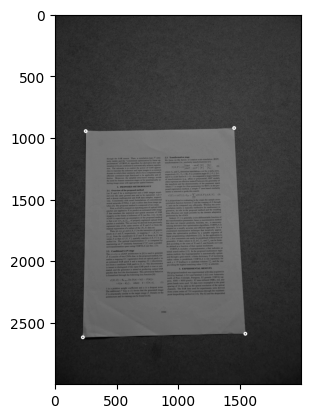

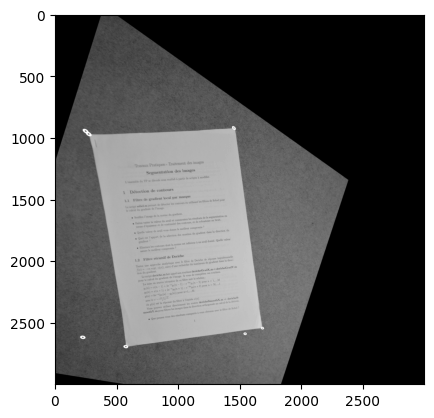

In [203]:
#first: creating errors in matching points of second image
pts1 = [[248,949],[1450,924],[1541,2592],[225,2621]] # Keypoints for img1. Should be a list in format [[first_point_row,first_point_column],[second_point_row,second_point_column],...]
pts2 = [[2040,92],[2750,904],[800,1500],[363,400]] #



for i in range(len(pts1)):
    img1c_dec=cv2.circle(img1,pts1[i],radius=10,color=(255,0,0),thickness=10)
plt.figure(),plt.imshow(img1c_dec,cmap='gray')

for i in range(len(pts2)):
    img2c_dec=cv2.circle(img2,pts2[i],radius=10,color=(255,0,0),thickness=10)
plt.figure(),plt.imshow(img2c_dec,cmap='gray')

pts1 = np.array(pts1).T # In all the following, we will use the convention that np.shape(pts1) = [2xnumber_of_points]
pts2 = np.array(pts2).T # In all the following, we will use the convention that np.shape(pts1) = [2xnumber_of_points

H = compute_homography(pts1,pts2)
homography_matrix_normalized = H / H[2, 2]
result = cv2.warpPerspective(img2, np.linalg.inv(homography_matrix_normalized),(3000,3000))
plt.imshow(result,cmap='gray')

[[2030, 110], [2750, 904], [920, 1638], [363, 663], [1515, 828]]
Normalizing data using similarity matrix...
[[ 248 1450 1541  225  866]
 [ 949  924 2592 2621 1771]]
Normalizing data using similarity matrix...
[[2030 2750  920  363 1515]
 [ 110  904 1638  663  828]]

Stacked matrix A shape: (10, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[ 1.88922620e-01 -5.96797226e-01  1.73636576e+03]
 [ 3.50500096e-01  2.01765705e-01 -2.10477561e+02]
 [-5.59706449e-05 -3.89254309e-06  6.15409309e-01]]


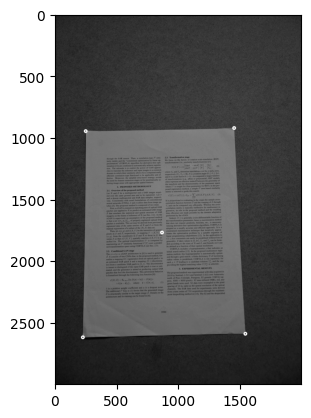

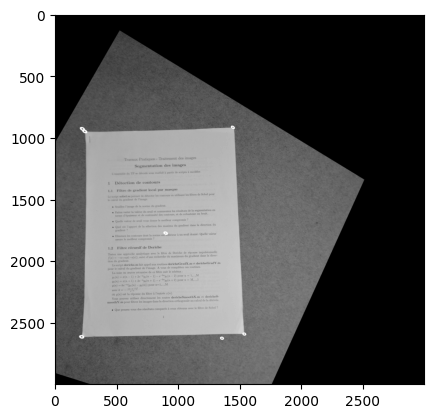

In [204]:
#now, adding more matching points, the new point we'll be the average 
pts1 = [[248,949],[1450,924],[1541,2592],[225,2621],[int(np.average([248,1450,1541,225])),int(np.average([949,924,2592,2621]))]] # Keypoints for img1. Should be a list in format [[first_point_row,first_point_column],[second_point_row,second_point_column],...]
pts2 = [[2030,110],[2750,904],[920,1638],[363,663],[int(np.average([2030,2750,920,363])),int(np.average([110,904,1638,663]))]] # Keypoints for img2,  keep the same order of the points as pts1.


print(pts2)
for i in range(len(pts1)):
    img1c_dec=cv2.circle(img1,pts1[i],radius=10,color=(255,0,0),thickness=10)
plt.figure(),plt.imshow(img1c_dec,cmap='gray')

for i in range(len(pts2)):
    img2c_dec=cv2.circle(img2,pts2[i],radius=10,color=(255,0,0),thickness=10)
plt.figure(),plt.imshow(img2c_dec,cmap='gray')

pts1 = np.array(pts1).T # In all the following, we will use the convention that np.shape(pts1) = [2xnumber_of_points]
pts2 = np.array(pts2).T # In all the following, we will use the convention that np.shape(pts1) = [2xnumber_of_points

H = compute_homography(pts1,pts2)
homography_matrix_normalized = H / H[2, 2]
result = cv2.warpPerspective(img2, np.linalg.inv(homography_matrix_normalized),(3000,3000))
plt.imshow(result,cmap='gray')

# Part 2: automatic homography estimation and panorama stitching

To bypass the flaws that we observed with the previous method, we now propose to use a robust homography estimation method, the RANSAC algorithm. As an application, we will consider panorama stitching: from two given overlapping images, create a single one which is a panorama. To do that, we will need to estimate the best homography to warp an image into the perspective of the other. In addition, to avoid the cumbersome choice of the matching points between the two images, we will do an automatic keypoint identification by using the SIFT features.

Let us first load the two considered images.

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x1b61fe1ef40>)

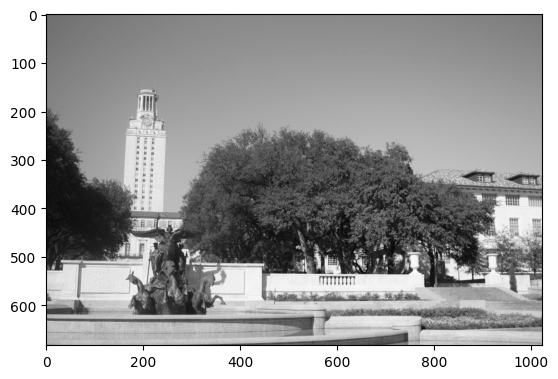

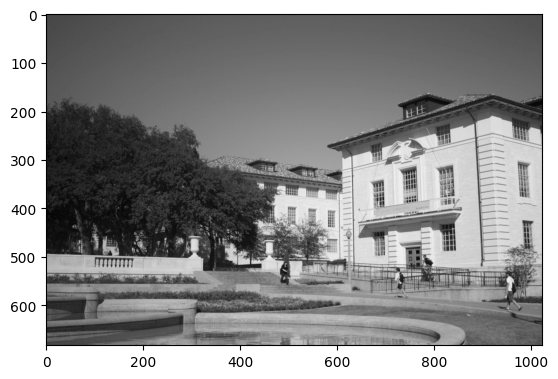

In [205]:
img1c = cv2.cvtColor(cv2.imread('uttower_left.jpg'),cv2.COLOR_BGR2GRAY)
img2c = cv2.cvtColor(cv2.imread('uttower_right.jpg'),cv2.COLOR_BGR2GRAY)

img1 = img1c
img2 = img2c

plt.figure(),plt.imshow(img1,cmap='gray')
plt.figure(),plt.imshow(img2,cmap='gray')

To stitch the two images, we need to have access to pair of corresponding points between image 1 and image 2. To do that, we first need to extract some keypoints in both images (that will be matched later on). We will use here the SIFT descriptors.

**Implement** the SIFT descriptors for both image 1 and image 2. You might be willing to use the cv2.SIFT_create and sift.detectAndCompute.

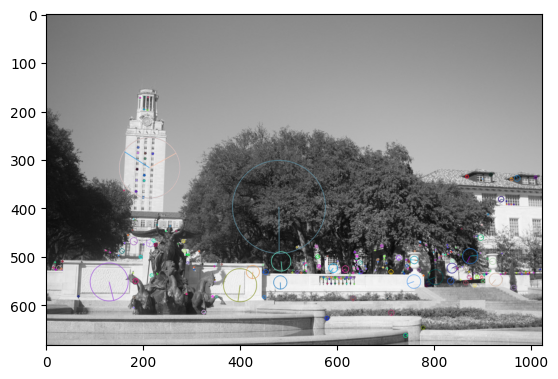

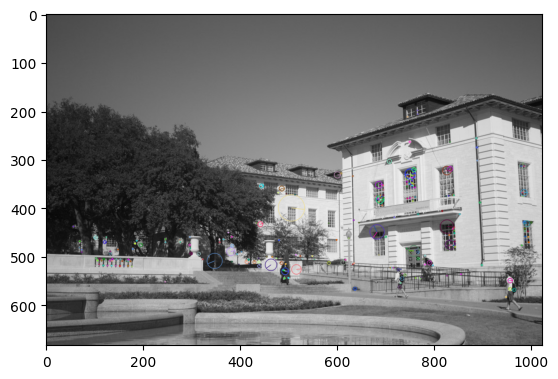

In [206]:
sift = cv2.SIFT_create(contrastThreshold=0.16) # Creates an object of the SIFT class. The larger the threshold, the smaller the number of points
kp1,desc1 = sift.detectAndCompute(img1, None) #kp1 = location of the keypoints, desc1 = corresponding descriptors.

# For visualization
img1c=cv2.drawKeypoints(img1,kp1,img1c,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img1c)
plt.show()

kp2,desc2 = sift.detectAndCompute(img2, None) #kp2 = location of the keypoints, desc2 = corresponding descriptors.
img2c=cv2.drawKeypoints(img2,kp2,img2c,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img2c)

**Question:** explain the shapes of desc1, kp1 and desc2, kp2 and their respective roles.

**Answer:**

kp1 and kp2 shapes are the number of keypoints found in the images 1 and 2 respectively (374)

desc1 and desc2 shapes are the number of keypoints times the number of descriptors found in the images 1 and 2 respectively (374,128)
we'll get 128 because a 16x16 neighbourhood around the keypoint is taken. It is divided into 16 sub-blocks of 4x4 size. For each sub-block, 8 bin orientation histogram is created. So a total of 128 bin values are available. It is represented as a vector to form keypoint descriptor.

The role of keypoints it that they're are specific points or regions in the image that are considered distinctive or salient. 

The role of the descriptors is that are numerical representations of the local image content surrounding each keypoint. They encode information about the local gradient or intensity distribution in the region surrounding the keypoint

In [207]:
print('Shape of kp1:')
print(np.array(kp1).shape)
print('Shape of desc1:')
print(np.array(desc1).shape)

print('Shape of kp2:')
print(np.array(kp2).shape)
print('Shape of desc2:')
print(np.array(desc2).shape)

Shape of kp1:
(374,)
Shape of desc1:
(374, 128)
Shape of kp2:
(374,)
Shape of desc2:
(374, 128)


Now that we have obtained the SIFT descriptor, we have to match them.

**Complete** the following code.

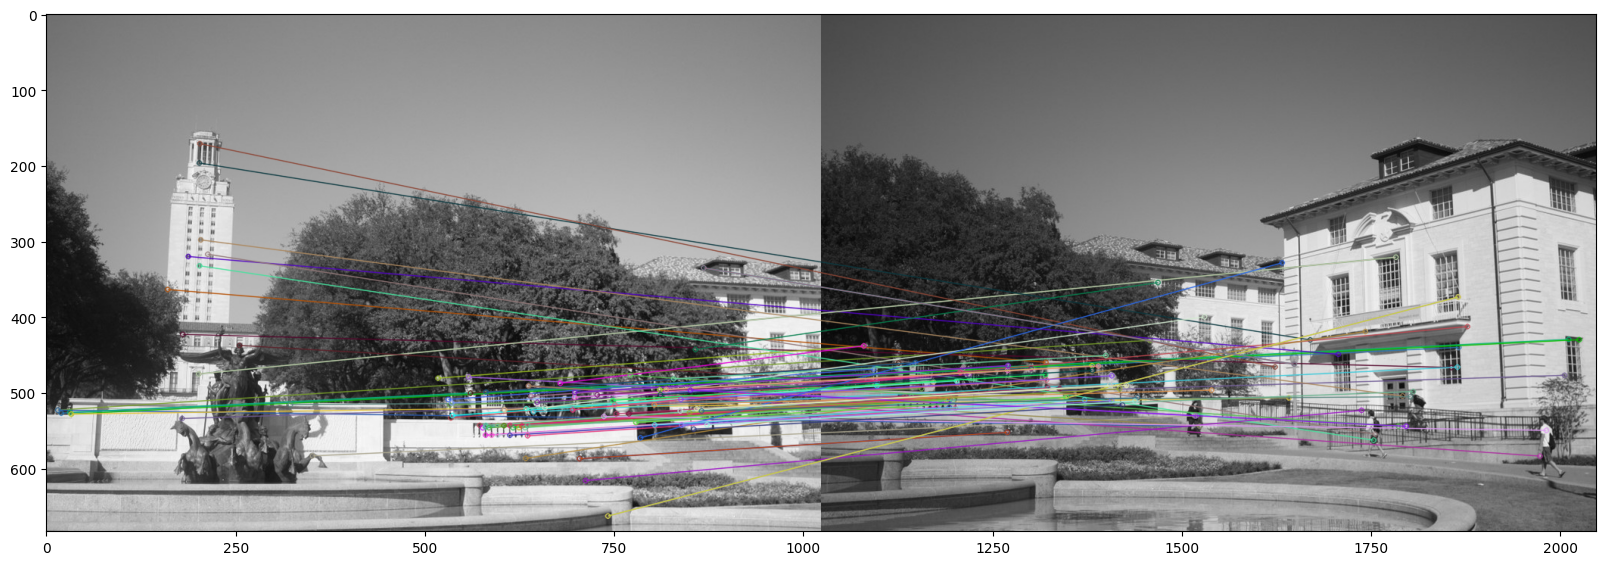

(<Figure size 2000x1200 with 1 Axes>,
 None)

In [208]:
#feature matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(desc1,desc2) 

#matches = bf.match(...,...) 


# For visualizing the matches
img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:100], img2, flags=2)
plt.figure(figsize=(20,12)),plt.imshow(img3),plt.show()

**Question:** comment the match quality. Do you think that the previous matching would enable a decent homography computation using the DLT algorithm of the first part?

**Answer:** We can see that there are some good mathces, like the ones of the little wall surrounding the three, but most of them are matching two builidings that are not the same. Since almost half tof the matches are wrong, due to the sensibility of DLT to outliers it would not behave well, so that, it would not lead to a decen homography computation

The following code enables to keep only the coordinates of the 100 best matches in the two images. We will use them as an input of a RANSAC, which will enable to do a robust homography estimation between the two images.

In [209]:
D1 = np.ones((2,100)) # Coordinates in image 1 of the first best matching points
D2 = np.ones((2,100)) # Coordinates in image 2 of the first best matching points
for ii in range(100):
    D1[:,ii] = kp1[matches[ii].queryIdx].pt
    D2[:,ii] = kp2[matches[ii].trainIdx].pt

D1 = D1.astype(int)
D2 = D2.astype(int)

In [210]:
print(D1.shape)

(2, 100)


Now, we are ready to code the RANSAC algorithm.

**Fill** the gaps in the code below.

In [211]:
def ransac(D1, D2, num, threshold, iterations):
    # D1, D2 : matched points between the two images
    # num : number of points to compute the homography
    # threshold : distance threshold for determining if a pair of point in an inlier or an outlier
    # iterations : number of iterations / number of sampling
    
    D1h = np.vstack((D1, np.ones(D1.shape[1]))) # D1h correspond to D1 transformed into homogeneous coordinates
    D1h[0:2,:] = np.divide(D1h[0:2,:],D1h[2,:])
    
    D2h = np.vstack((D2, np.ones(D2.shape[1]))) # D2h correspond to D2 transformed into homogeneous coordinates
    D2h[0:2,:] = np.divide(D2h[0:2,:],D2h[2,:])
        
    n = D1.shape[1] # Number of points in D1
    

    best_n_inlier = 0
    best_H = np.zeros(D1h.shape) # Best homography matrix. Fill the gap with a matrix of the right size full of 0.
    
    for i in range(iterations):
        s = np.random.choice(n, num, replace=False) # Draw randomly 4 indices to extract 4 points among D1 and D2. You can use np.random.choice()
        
        pts1 =  D1[:, s] #pts1 is the chosen points among D1
        pts2 =  D2[:, s] #pts2 is the chosen points among D2
        
        H = compute_homography(pts1,pts2) # Compute the corresponding homography. You can reuse the function of part I.
        
        D2_new = np.dot(H, D1h) # Transform the points of D1h to be able to compare them to the ones of D2h
        
        # Normalize D2_new
        D2_new[0, :] = np.divide(D2_new[0, :],D2_new[2, :])
        D2_new[1, :] = np.divide(D2_new[1, :],D2_new[2, :])
        D2_new[2, :] = np.divide(D2_new[2, :],D2_new[2, :])
        
        
        
        SD = np.sqrt(np.sum((D2_new - D2h)**2, axis = 0))# Compute the distance between D2_new and D2h
        
        inliers = SD < threshold # Compute the inliers
		#have my doubts here
        num_inlier = np.sum(inliers)# Compute the number of inliers
        
        if num_inlier > best_n_inlier: # If you obtained the best result, store the corresponding homography
            best_H = H
            best_n_inlier = num_inlier
            point1 = D1[:2, inliers]
            point2 = D2[:2, inliers]
            in_res = SD[inliers]
    
    
    return best_H, best_n_inlier, point1, point2, in_res

Using the function you implemented above, **launch the RANSAC algorithm** to estimate the homography between the two images.

In [212]:
threshold = 1;
num = 4;
iterations = 1000;
[H, inliers, point1, point2, residue] = ransac(D1, D2, num,threshold, iterations)

Normalizing data using similarity matrix...
[[637 643 634 803]
 [490 525 520 542]]
Normalizing data using similarity matrix...
[[499 840 178 347]
 [543 466 484 509]]

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[ 2.89353772e+00 -3.62183673e+00  4.32734749e+01]
 [ 4.13386166e+00 -4.14596062e+00 -4.80137843e+02]
 [ 8.07303939e-03 -7.70279587e-03 -1.14419418e+00]]
Normalizing data using similarity matrix...
[[698 580 855  31]
 [499 499 547 525]]
Normalizing data using similarity matrix...
[[246 124 397 987]
 [464 460 516 429]]

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[-5.03460999e-01 -7.64009865e-01  6.39694264e+02]
 [-4.31094277e-01 -5.87575528e-01  4.18760213e+02]
 [-9.09313567e-04 -1.03743542e-04  3.08572818e-01]]
Normalizing data using similarity matrix...
[[636 572 736 810]
 [542 542 531 4

C:\Users\aleja\AppData\Local\Temp\ipykernel_11196\1605541544.py:30: RuntimeWarning: invalid value encountered in divide
  D2_new[0, :] = np.divide(D2_new[0, :],D2_new[2, :])
C:\Users\aleja\AppData\Local\Temp\ipykernel_11196\1605541544.py:31: RuntimeWarning: invalid value encountered in divide
  D2_new[1, :] = np.divide(D2_new[1, :],D2_new[2, :])
C:\Users\aleja\AppData\Local\Temp\ipykernel_11196\1605541544.py:32: RuntimeWarning: invalid value encountered in divide
  D2_new[2, :] = np.divide(D2_new[2, :],D2_new[2, :])


Normalizing data using similarity matrix...
[[855 213 202 859]
 [547 316 196 520]]
Normalizing data using similarity matrix...
[[397 731 645 403]
 [516 554 430 490]]

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[ 1.47495582e-01 -5.43959710e-01  3.07093734e+02]
 [ 1.65071700e-01 -2.42128314e-01  1.67627159e+02]
 [ 5.83489870e-04 -1.12913195e-03  4.60455355e-01]]
Normalizing data using similarity matrix...
[[612 742 643 588]
 [543 662 525 555]]
Normalizing data using similarity matrix...
[[153 841 840 126]
 [505 373 466 518]]

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[ 2.60710611e+00  5.49235238e+00 -4.56913375e+03]
 [ 5.67028443e-01  2.86932682e+00 -1.87614380e+03]
 [ 2.03510061e-03  7.30036701e-03 -5.15230943e+00]]
Normalizing data using similarity matrix...
[[179 612  19 351]
 [533 543 526 5

In [213]:
print(H)

[[ 7.06059344e-01 -7.11083876e-02 -2.96403888e+02]
 [ 1.01895890e-01  6.34971476e-01 -8.56348684e+01]
 [ 1.74679524e-04 -4.45108190e-05  5.52505676e-01]]


Lastly, **fill the code** below to warp img2 into the same space as img1

In [214]:
result = cv2.warpPerspective(img2, np.linalg.inv(H),(img1.shape[1] + img2.shape[1], img1.shape[0]))
result[0:img1.shape[0], 0:img1.shape[1]] = img1

**Question:** Plot the panorama image. How good is it? Any comment?

We have a good panorama due to the robustness to outliers of the RANSAC algorithm since it is designed to handle datasets that contain outliers by iteratively refining the estimated model by fitting it to multiple random subsets of the data and selecting the model that has the largest number of inliers. However, is not a deterministic algorithm due to the randomness nature of the algorithm when selecting the subset

(<Figure size 4000x2000 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x1b61fee92e0>)

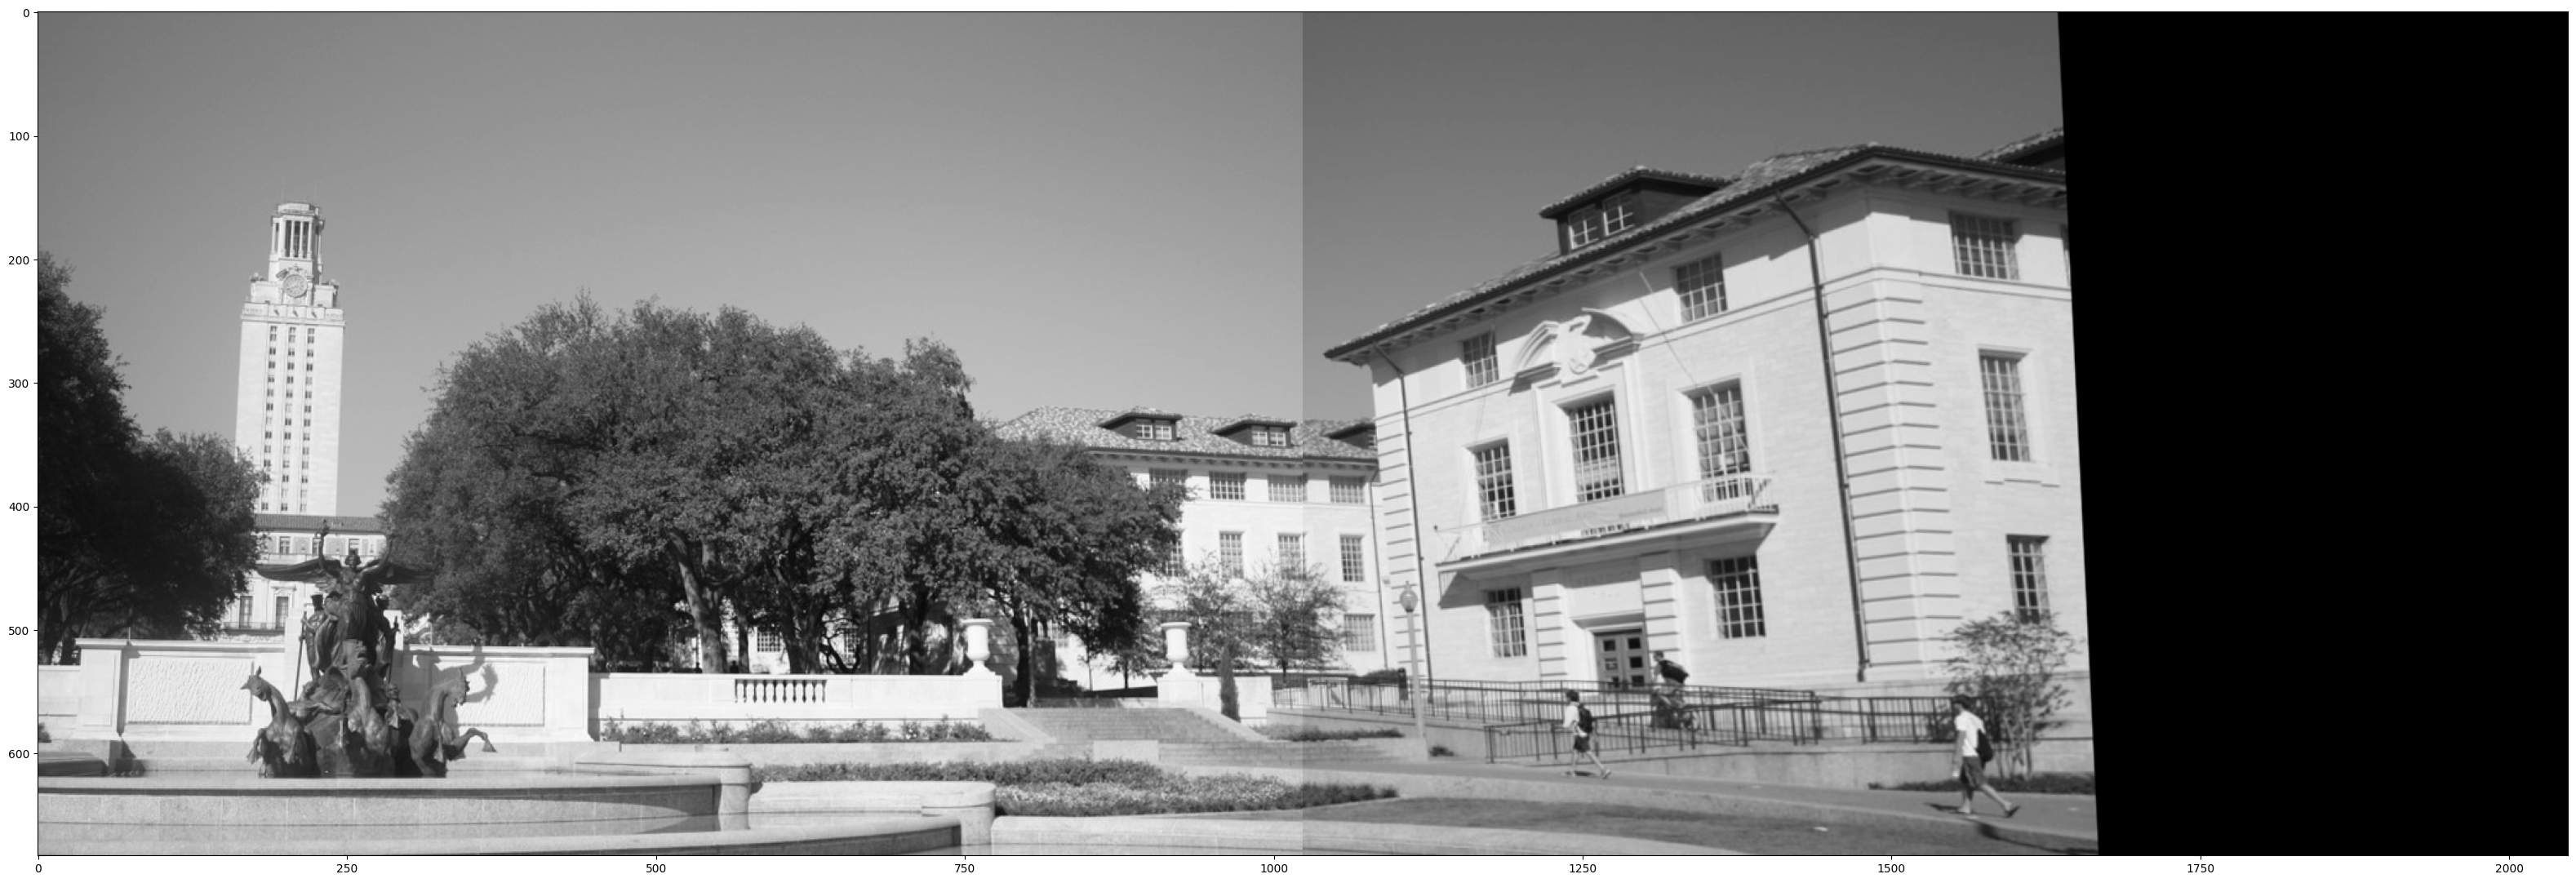

In [215]:
plt.figure(figsize=(40,20)),plt.imshow(result,cmap='gray')

**Bonus**: try other descriptors than the SIFT ones. Try to implement your own.

**Bonus:** try to correct the change of luminosity between the two images so that the panorama look more realistic.